In [1]:
#Importando as bibliotecas
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.utils import to_categorical
import os
from tensorflow.keras.callbacks import TensorBoard
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
import time
import pandas as pd
import tensorflow_hub as hub


plt.style.use('fivethirtyeight')

**Etapa 1: Preparando os dados**

In [2]:
#Como existem cinco pastas armazenando seu caminho de arquivo em cinco variáveis diferentes
Train_Cezanne_path="archive/training/training/Cezanne"
Train_VanGogh_path="archive/training/training/VanGogh"
Train_Degas_path="archive/training/training/Degas"
Train_Gauguin_path="archive/training/training/Gauguin"
Train_Hassam_path="archive/training/training/Hassam"

Validation_Cezanne_path="archive/validation/validation/Cezanne"
Validation_VanGogh_path="archive/validation/validation/VanGogh"
Validation_Degas_path="archive/validation/validation/Degas"
Validation_Gauguin_path="archive/validation/validation/Gauguin"
Validation_Hassam_path="archive/validation/validation/Hassam"

Test_Cezanne_path="archive/test/Cezanne"
Test_Degas_path="archive/test/Degas"
Test_VanGogh_path="archive/test/VanGogh"
Test_Gauguin_path="archive/test/Gauguin"
Test_Hassam_path="archive/test/Hassam"


In [3]:
#Criar uma lista para armazenar todos os caminhos de arquivo de treinamento

Cezanne_train_files=[]
Cezanne_train=list()
Degas_train=list()
VanGogh_train = list()
Hassam_train = list()
Gauguin_train = list()

# listdir lista todos os arquivos em um determinado caminho de arquivo e armazena-o na lista
Cezanne_train_files=os.listdir(Train_Cezanne_path)
Degas_train_files=os.listdir(Train_Degas_path)
VanGogh_train_files=os.listdir(Train_VanGogh_path)
Gauguin_train_files=os.listdir(Train_Gauguin_path)
Hassam_train_files=os.listdir(Train_Hassam_path)

#Por enquanto, só obtemos o nome do arquivo como em (01.jpg), portanto, acrescentando o caminho do arquivo com o nome do arquivo
for i in range(len(os.listdir(Train_Cezanne_path))):
    Cezanne_train.append(Train_Cezanne_path+"/"+str(Cezanne_train_files[i]))
for i in range(len(os.listdir(Train_Degas_path))):
    Degas_train.append(Train_Degas_path+"/"+str(Degas_train_files[i]))
for i in range(len(os.listdir(Train_VanGogh_path))):
    VanGogh_train.append(Train_VanGogh_path+"/"+str(VanGogh_train_files[i]))
for i in range(len(os.listdir(Train_Gauguin_path))):
    Gauguin_train.append(Train_Gauguin_path+"/"+str(Gauguin_train_files[i]))
for i in range(len(os.listdir(Train_Hassam_path))):
    Hassam_train.append(Train_Hassam_path+"/"+str(Hassam_train_files[i]))

In [4]:
#Verificando todo o tamanho dos dados de treinamento
len(Cezanne_train)+len(Degas_train)+len(VanGogh_train)+len(Gauguin_train)+len(Hassam_train)

1994

In [5]:
Train_df=pd.DataFrame()

In [6]:
# Criar um quadro de dados de treinamento com o caminho das imagens e seu valor alvo
Train_df=pd.DataFrame({"ID":Cezanne_train,"Target":"Cezanne"})

In [7]:
len(Train_df)

399

In [8]:
Train_df["ID"][0],Train_df["Target"][0]

('archive/training/training/Cezanne/215541.jpg', 'Cezanne')

In [9]:
# Criar um quadro de dados de treinamento com o caminho das imagens e seu valor alvo
Degas_df=pd.DataFrame({"ID":Degas_train,"Target":"Degas"})
VanGogh_df=pd.DataFrame({"ID":VanGogh_train,"Target":"VanGogh"})
Gauguin_df=pd.DataFrame({"ID":Gauguin_train,"Target":"Gauguin"})
Hassam_df=pd.DataFrame({"ID":Hassam_train,"Target":"Hassam"})
# Combinnando os pintores no dataframe de treinamento
Train_df=Train_df.append(Degas_df, ignore_index=False)
Train_df=Train_df.append(Hassam_df, ignore_index=False)
Train_df=Train_df.append(VanGogh_df, ignore_index=False) 
Train_df=Train_df.append(Gauguin_df, ignore_index=False) 

In [10]:
len(Train_df)

1994

In [11]:
# Embaralhando todo o quadro de dados como na primeira e última ordem 
Train_df=Train_df.sample(frac=1)

In [12]:
Train_df.head()

,ID,Target
398,archive/training/training/Cezanne/215543.jpg,Cezanne
35,archive/training/training/Hassam/244313.jpg,Hassam
41,archive/training/training/Cezanne/215604.jpg,Cezanne
19,archive/training/training/Hassam/243950.jpg,Hassam
127,archive/training/training/Gauguin/190737.jpg,Gauguin


In [13]:
#Buscando todos os nomes de arquivo do dataframe de treinamento e armazenando-os como lista
All_training_files=[fname for fname in Train_df["ID"]]

In [14]:
All_training_files[:7]

['archive/training/training/Cezanne/215543.jpg',
 'archive/training/training/Hassam/244313.jpg',
 'archive/training/training/Cezanne/215604.jpg',
 'archive/training/training/Hassam/243950.jpg',
 'archive/training/training/Gauguin/190737.jpg',
 'archive/training/training/VanGogh/206804.jpg',
 'archive/training/training/VanGogh/206343.jpg']

In [15]:
# Convertendo a variável de destino em numpy
labels=Train_df["Target"].to_numpy()

In [16]:
labels[:10]

array(['Cezanne', 'Hassam', 'Cezanne', 'Hassam', 'Gauguin', 'VanGogh',
       'VanGogh', 'Gauguin', 'Gauguin', 'VanGogh'], dtype=object)

In [17]:
# Encontrar os valores únicos nos rótulos, pois há apenas dois alvos que precisam ser previstos
true_labels=np.unique(labels)

In [18]:
len(true_labels)

5

In [19]:
labels[1]==true_labels

array([False, False, False,  True, False])

In [20]:
boolean_labels=[labels == true_labels for labels in labels]
len(boolean_labels)

1994

In [21]:
print(labels[0])
print(np.where(true_labels[0]==labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

Cezanne
(array([0]),)
0
[1 0 0 0 0]


In [22]:
boolean_labels[0]

array([ True, False, False, False, False])

In [23]:
Train_df.tail()

,ID,Target
16,archive/training/training/Degas/213815.jpg,Degas
119,archive/training/training/VanGogh/206094.jpg,VanGogh
393,archive/training/training/Cezanne/215953.jpg,Cezanne
148,archive/training/training/Cezanne/215671.jpg,Cezanne
182,archive/training/training/Degas/213458.jpg,Degas


In [24]:
# Criação da variável de recurso e variável de destino
X=All_training_files
y=boolean_labels

In [25]:
# Experimentando amostras de 2k
NUM_IMAGES=2000

In [26]:
Cezanne_val_files=[]
Cezanne_val=list()
Degas_val=list()
VanGogh_val=list()
Gauguin_val=list()
Hassam_val=list()

#Armazenando todos os arquivos em um determinado caminho de arquivo em duas variáveis
Cezanne_val_files=os.listdir(Validation_Cezanne_path)
Degas_val_files=os.listdir(Validation_Degas_path)
VanGogh_val_files=os.listdir(Train_VanGogh_path)
Gauguin_val_files=os.listdir(Train_Gauguin_path)
Hassam_val_files=os.listdir(Train_Hassam_path)

# Anexando o caminho do arquivo com o nome do arquivo
for i in range(len(os.listdir(Validation_Cezanne_path))):
    Cezanne_val.append(Validation_Cezanne_path+"/"+str(Cezanne_val_files[i]))
for i in range(len(os.listdir(Validation_Degas_path))):
    Degas_val.append(Validation_Degas_path+"/"+str(Degas_val_files[i]))
for i in range(len(os.listdir(Validation_VanGogh_path))):
    VanGogh_val.append(Validation_VanGogh_path+"/"+str(VanGogh_val_files[i]))
for i in range(len(os.listdir(Validation_Gauguin_path))):
    Gauguin_val.append(Validation_Gauguin_path+"/"+str(Gauguin_val_files[i]))
for i in range(len(os.listdir(Validation_Hassam_path))):
    Hassam_val.append(Validation_Hassam_path+"/"+str(Hassam_val_files[i]))

In [27]:
Hassam_val[1]

'archive/validation/validation/Hassam/244090.jpg'

In [28]:
# criando um dataframe
Valid_df=pd.DataFrame({"ID":Cezanne_val,"Target":"Cezanne"})
new_val_row=pd.DataFrame({"ID":Degas_val,"Target":"Degas"})
new_val_row2=pd.DataFrame({"ID":VanGogh_val,"Target":"VanGogh"})
new_val_row3=pd.DataFrame({"ID":Gauguin_val,"Target":"Gauguin"})
new_val_row4=pd.DataFrame({"ID":Hassam_val,"Target":"Hassam"})

#Combinando-os
Valid_df=Valid_df.append(new_val_row,ignore_index=True)
Valid_df=Valid_df.append(new_val_row2,ignore_index=True)
Valid_df=Valid_df.append(new_val_row3,ignore_index=True)
Valid_df=Valid_df.append(new_val_row4,ignore_index=True)

In [29]:
Valid_df

,ID,Target
0,archive/validation/validation/Cezanne/215541.jpg,Cezanne
1,archive/validation/validation/Cezanne/215992.jpg,Cezanne
2,archive/validation/validation/Cezanne/215622.jpg,Cezanne
3,archive/validation/validation/Cezanne/215596.jpg,Cezanne
4,archive/validation/validation/Cezanne/215763.jpg,Cezanne
...,...,...
1989,archive/validation/validation/Hassam/244290.jpg,Hassam
1990,archive/validation/validation/Hassam/244057.jpg,Hassam
1991,archive/validation/validation/Hassam/244139.jpg,Hassam
1992,archive/validation/validation/Hassam/243990.jpg,Hassam


In [30]:
#emparalhando os dados
Valid_df=Valid_df.sample(frac=1)

In [31]:
Valid_df.tail()

,ID,Target
818,archive/validation/validation/VanGogh/206311.jpg,VanGogh
778,archive/validation/validation/Degas/213781.jpg,Degas
852,archive/validation/validation/VanGogh/205841.jpg,VanGogh
1679,archive/validation/validation/Hassam/244154.jpg,Hassam
1756,archive/validation/validation/Hassam/244397.jpg,Hassam


In [32]:
# Obtendo todos os caminhos de arquivo do dataframe de validação
All_val_files=[fname for fname in Valid_df["ID"]]

In [33]:
All_val_files[:5]

['archive/validation/validation/Cezanne/215798.jpg',
 'archive/validation/validation/Cezanne/215648.jpg',
 'archive/validation/validation/VanGogh/206038.jpg',
 'archive/validation/validation/Degas/213505.jpg',
 'archive/validation/validation/VanGogh/206343.jpg']

In [34]:
val_labels=Valid_df["Target"].to_numpy()
val_labels[:10]

array(['Cezanne', 'Cezanne', 'VanGogh', 'Degas', 'VanGogh', 'Cezanne',
       'Degas', 'VanGogh', 'Cezanne', 'Hassam'], dtype=object)

In [35]:
val_true_labels=np.unique(val_labels)
len(val_true_labels)

5

In [36]:
boolean_val_labels=[labels==val_true_labels for labels in val_labels ]
boolean_val_labels[:10]

[array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([False, False, False, False,  True]),
 array([False,  True, False, False, False]),
 array([False, False, False, False,  True]),
 array([ True, False, False, False, False]),
 array([False,  True, False, False, False]),
 array([False, False, False, False,  True]),
 array([ True, False, False, False, False]),
 array([False, False, False,  True, False])]

In [37]:
# Divisão de dados em conjunto de treinamento e validação
X_train,y_train=All_training_files[:NUM_IMAGES],boolean_labels[:NUM_IMAGES]
X_val,y_val=All_val_files[:2000],boolean_val_labels[:2000]

In [38]:
len(X_train)

1994

**Etapa 2: Transformando os dados em tensores**

In [39]:
IMG_SIZE=224
# Criar uma função que pode pré-processar os dados
def preprocess_data(image_path,img_size=IMG_SIZE):
    #Lendo o caminho da imagem
    image=tf.io.read_file(image_path)
    #Transformando a imagem em tensores numéricos do canal de cor
    image=tf.image.decode_jpeg(image,channels=3)
    #Convertendo os canais de cor de 0-255 valores para 0-1
    image=tf.image.convert_image_dtype(image,tf.float32)
    #Redimensione nossas imagens para o valor desejado 224
    image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
    return image

In [40]:
#Função para retornar uma tupla de imagem pré-processada em tensores de formulário e seus respectivos rótulos
def get_image_label(image_path,label):
    image=preprocess_data(image_path)
    return image,label

In [41]:
# Função para transformar todos os nossos X e y em lotes de dados

BATCH_SIZE=32
def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    #se forem dados de treinamento, não haverá rótulos
    if test_data==True:
        print("Create test data batches....")
        data=tf.data.Dataset.from_tensor_slices((tf.context(X)))
        data_batch=data.map(preprocess_data).batch(BATCH_SIZE)
        return data_batch
    # se são dados válidos
    elif valid_data==True:
        print("Create validation data batches.....")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data_batch=data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    # se os dados são treinados
    else:
        print("Creating training data batches....")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data=data.map(get_image_label)
        data_batch=data.batch(BATCH_SIZE)
        return data_batch

In [42]:
len(X_train),len(X_val)

(1994, 1994)

In [43]:
# Cria lotes de dados de treinamento e validação
train_data=create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val,valid_data=True)

Creating training data batches....
Create validation data batches.....


In [44]:
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)))

**Visualizando os lotes de dados**

In [45]:
import matplotlib.pyplot as plt
def show_25_images(images,label):
    # configurar uma figura
    plt.figure(figsize=(10,10))
    # percorrer 25 imagens
    for i in range(25):
        # Crie subtramas (5 linhas, 5 colunas)
        ax=plt.subplot(5,5,i+1)
        # Exibir uma imagem
        plt.imshow(images[i])
        # Adicionar rótulo de imagem como título
        plt.title(true_labels[label[i].argmax()])
        # Desligue as linhas de grade
        plt.axis("off")

In [46]:
len(val_data)

63

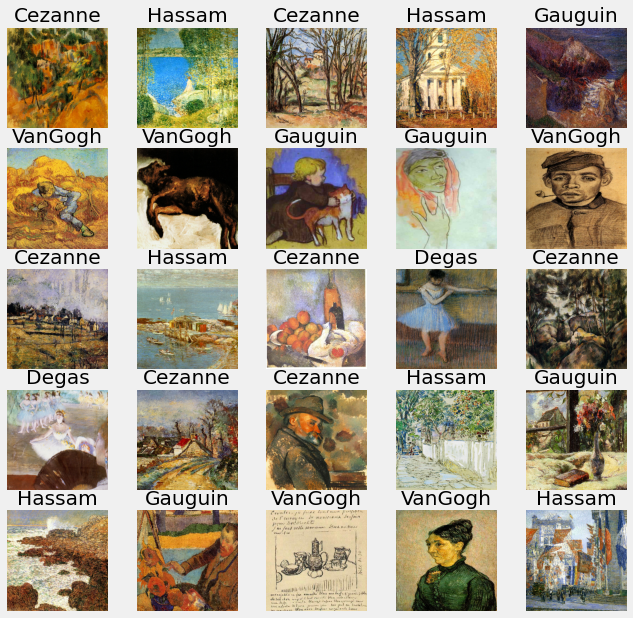

In [47]:
# Desbloqueia os dados usando as_numpy_iterator
train_images,train_labels=next(train_data.as_numpy_iterator())
# Agora vamos visualizar as imagens no lote de treinamento
show_25_images(train_images,train_labels)

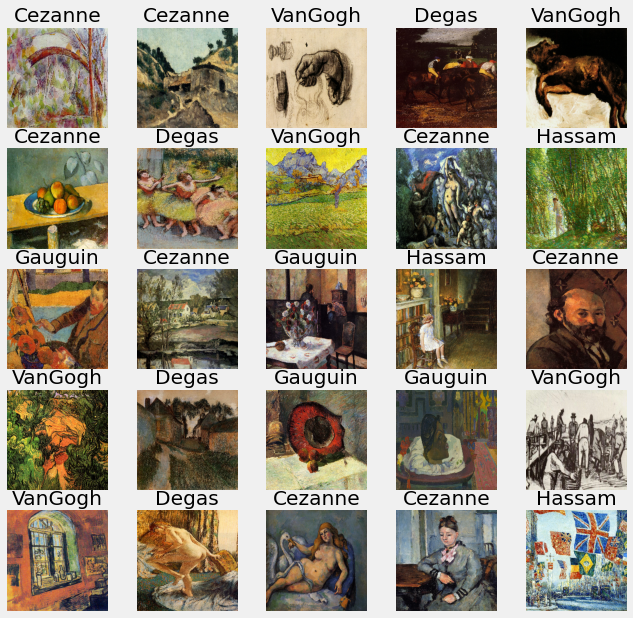

In [48]:
# Agora vamos visualizar as imagens no lote de validação
val_images,val_labels=next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

**Passo 3: Constroi um modelo de aprendizado de máquina**

In [49]:
# Configurando uma forma de entrada
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3]

# Configurar um formato de saída
OUTPUT_SHAPE=len(true_labels)

# Model URL
MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [50]:
# Construindo um modelo keras
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
    model=tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL),
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                             activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]

  )

    # contruindo o modelo
    model.build(INPUT_SHAPE)

    return model

In [51]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 5)                 5010      
Total params: 5,437,723
Trainable params: 5,010
Non-trainable params: 5,432,713
_________________________________________________________________


In [52]:
%load_ext tensorboard

In [53]:
# Cria um retorno de chamada de parada antecipada
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

In [54]:
NUM_EPOCHS=3

In [55]:
import datetime
# Crie uma função para construir um retorno de chamada do TensorBoard
def create_tensorboard_callback():
    # Crie um diretório de registro para armazenar registros do TensorBoard
    logdir=os.path.join("./working/",
                      # Faça com que os logs sejam rastreados sempre que executamos a expiração
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir) 

In [56]:
# Crie uma função para treinar um modelo e retornar um modelo treinado
def train_model():
    # Crie um modelo
    model=create_model()

    # Cria uma nova sessão toda vez que treinamos um modelo
    tensorboard=create_tensorboard_callback()

    # Ajustar o modelo aos dados, passando os callbacks que criamos
    model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
    return model

In [57]:
model=train_model()

Epoch 1/3
 1/63 [..............................] - ETA: 0s - loss: 3.5867 - accuracy: 0.0938WARNING:tensorflow:From /home/elaine/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


63/63 [==============================] - 410s 7s/step - loss: 1.3204 - accuracy: 0.5466 - val_loss: 0.7197 - val_accuracy: 0.7462
Epoch 2/3
63/63 [==============================] - 405s 6s/step - loss: 0.6459 - accuracy: 0.7773 - val_loss: 0.5181 - val_accuracy: 0.8320
Epoch 3/3
63/63 [==============================] - 394s 6s/step - loss: 0.5123 - accuracy: 0.8260 - val_loss: 0.4309 - val_accuracy: 0.8626


In [58]:
len(val_data)

63

In [59]:
# Faça previsões sobre os dados de validação
predictions=model.predict(val_data,verbose=1)

63/63 [==============================] - 203s 3s/step


In [60]:
predictions[:10]

array([[6.9335771e-01, 5.3576741e-02, 7.6831058e-02, 1.2711689e-01,
        4.9117599e-02],
       [7.5417233e-01, 5.2117924e-03, 1.3928634e-01, 6.9907196e-02,
        3.1422459e-02],
       [1.4416396e-03, 5.1111147e-02, 4.2719422e-03, 1.1557692e-02,
        9.3161756e-01],
       [6.8031240e-01, 2.2552244e-01, 5.9901502e-02, 2.5495917e-02,
        8.7676411e-03],
       [1.9238645e-01, 7.8201473e-01, 7.9255747e-03, 4.7680188e-04,
        1.7196363e-02],
       [8.8344145e-01, 1.0656881e-03, 1.0107552e-01, 3.3889597e-03,
        1.1028393e-02],
       [4.6178829e-03, 9.6034765e-01, 2.8681369e-02, 1.5531614e-03,
        4.7998447e-03],
       [2.9396012e-03, 8.1295910e-04, 2.0335777e-02, 7.7817137e-03,
        9.6812999e-01],
       [9.4173491e-01, 3.4619495e-02, 2.1589316e-02, 2.2280501e-04,
        1.8335028e-03],
       [8.7960754e-05, 1.1799694e-04, 7.2580436e-04, 7.7679461e-01,
        2.2227369e-01]], dtype=float32)

In [61]:
predictions.shape

(1994, 5)

In [62]:
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") #  o valor de probabilidade máxima predito pelo modelo
print(f"Max index: {np.argmax(predictions[0])}") # o índice de onde ocorre o valor máximo nas previsões [0]
print(f"Predicted label: {true_labels[np.argmax(predictions[0])]}")

[0.6933577  0.05357674 0.07683106 0.12711689 0.0491176 ]
Max value (probability of prediction): 0.6933577060699463
Max index: 0
Predicted label: Cezanne


In [63]:
# Transforme as probabilidades de previsão em seus respectivos rótulos (mais fácil de entender)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return true_labels[np.argmax(prediction_probabilities)]

# Obtenha um rótulo previsto com base em uma série de probabilidades de previsão
pred_label = get_pred_label(predictions[0])
pred_label

'Cezanne'

In [64]:
len(val_data)

63

In [65]:
# Crie uma função para desbloquear um conjunto de dados em lote
def unbatchify(data):
    
    images = []
    labelss = []
    # Loop através de dados não bloqueados
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labelss.append(true_labels[np.argmax(label)])
    return images, labelss

# Desbloqueia os dados de validação
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.7145659 , 0.7407913 , 0.34138656],
         [0.70976204, 0.74113464, 0.33721304],
         [0.68400985, 0.73499024, 0.37637684],
         ...,
         [0.88199115, 0.9094421 , 0.8388539 ],
         [0.8996015 , 0.9231309 , 0.868229  ],
         [0.87412333, 0.89765275, 0.8505939 ]],
 
        [[0.6817783 , 0.7036621 , 0.33614823],
         [0.6397078 , 0.66974986, 0.2728248 ],
         [0.65727603, 0.7025842 , 0.36469963],
         ...,
         [0.90444756, 0.93189853, 0.8613103 ],
         [0.88027954, 0.9052302 , 0.84717673],
         [0.87563676, 0.90308774, 0.83383006]],
 
        [[0.6972458 , 0.7207752 , 0.37282977],
         [0.6857869 , 0.7255634 , 0.41701937],
         [0.6682986 , 0.7075143 , 0.32686326],
         ...,
         [0.88494295, 0.9123939 , 0.8418057 ],
         [0.8775209 , 0.9049719 , 0.83438367],
         [0.8926945 , 0.9162239 , 0.8613219 ]],
 
        ...,
 
        [[0.7081602 , 0.701204  , 0.6140181 ],
         [0.78267205, 0.7265807 , 0.63998

In [66]:
len(val_images)

1994

In [67]:
def plot_pred(prediction_probabilities, labels, images, n=0):
    
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
    # Obtenha o rótulo pred
    pred_label = get_pred_label(pred_prob)
  
  # Plotar imagem e remover ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

  # Altere a cor do título dependendo se a previsão está certa ou errada
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

In [68]:
len(predictions)

1994

In [69]:
len(val_labels)

1994

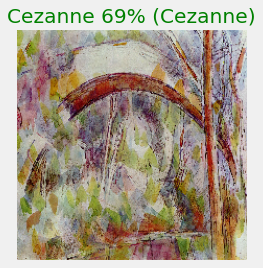

In [70]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [71]:
model.evaluate(val_data)

63/63 [==============================] - 217s 3s/step - loss: 0.4309 - accuracy: 0.8626


[0.43086203932762146, 0.8625877499580383]

In [72]:
len(X)

1994

In [73]:
X=All_training_files[:90000]
y=boolean_labels[:90000]

In [74]:
X_val,y_val=All_val_files,boolean_val_labels

In [75]:
# Criação de lotes completos de dados de treinamento e validação
Full_training_data=create_data_batches(X,y)
Full_validation_data=create_data_batches(X_val,y_val,valid_data=True)

Creating training data batches....
Create validation data batches.....


In [76]:
len(Full_training_data)

63

In [77]:
full_model=create_model()

In [78]:
# Crie callback de modelo completo

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# parada antercipada do callback
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [79]:
NUM_EPOCHS

3

In [80]:
full_model.fit(x=Full_training_data,
            epochs=NUM_EPOCHS,
            validation_data=Full_validation_data,
            validation_freq=1,
            callbacks=[early_stopping])

Epoch 1/3
63/63 [==============================] - 507s 8s/step - loss: 1.1973 - accuracy: 0.5642 - val_loss: 0.7034 - val_accuracy: 0.7432
Epoch 2/3
63/63 [==============================] - 478s 8s/step - loss: 0.6432 - accuracy: 0.7588 - val_loss: 0.5136 - val_accuracy: 0.8245
Epoch 3/3
63/63 [==============================] - 445s 7s/step - loss: 0.5105 - accuracy: 0.8240 - val_loss: 0.4268 - val_accuracy: 0.8616


In [81]:
# Armazena todos os testes em uma pasta
Cezanne_test_files=[]
Cezanne_test=list()
Degas_test=list()
Cezanne_test_files=os.listdir(Test_Cezanne_path)
Degas_test_files=os.listdir(Test_Degas_path)
for i in range(len(os.listdir(Test_Cezanne_path))):
    Cezanne_test.append(Test_Cezanne_path+"/"+str(Cezanne_test_files[i]))
for i in range(len(os.listdir(Test_Degas_path))):
    Degas_test.append(Test_Degas_path+"/"+str(Degas_test_files[i]))

In [82]:
#Cria um dataframe para o teste
Test_df=pd.DataFrame()
Test_df=pd.DataFrame({"ID":Cezanne_test,"Target":"Cezanne"})
new_test_row=pd.DataFrame({"ID":Degas_test,"Target":"Degas"})
Test_df=Test_df.append(new_test_row,ignore_index=False)
#sorteia um dataframe
Test_df=Test_df.sample(frac=1)

In [83]:
Test_df.head()

,ID,Target
5,archive/test/Degas/213484.jpg,Degas
70,archive/test/Degas/213263.jpg,Degas
79,archive/test/Degas/213761.jpg,Degas
54,archive/test/Cezanne/215726.jpg,Cezanne
49,archive/test/Degas/213782.jpg,Degas


In [84]:
len(Test_df)

198

In [85]:
X_test,y_test=Test_df["ID"][:10000],Test_df["Target"][:10000]

In [86]:
len(X_test)

198

In [87]:
test_data=create_data_batches(X_test,y_test)

Creating training data batches....


**Etapa 3: fazer previsões em todo o conjunto de dados de teste**

In [88]:
# fazer previsões em todo o conjunto de dados de teste
test_predictions=full_model.predict(test_data,verbose=1)

7/7 [==============================] - 26s 4s/step


In [89]:
test_predictions.shape

(198, 5)

In [90]:
test_images,test_labels=unbatchify(test_data)

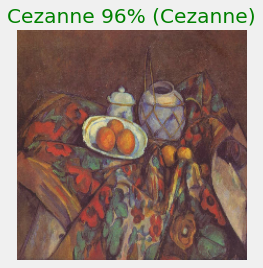

In [91]:
plot_pred(prediction_probabilities=test_predictions,
          labels=test_labels,
          images=test_images,n=180)

In [92]:
def show_test_25_images(images,label,predictions):
    # Configura uma figura
    plt.figure(figsize=(10,10))
    # lool de 25 imagens
    for i in range(25):
        # Crie subtramas (5 linhas, 5 colunas)
        ax=plt.subplot(5,5,i+1)
        # Exibir uma imagem
        plot_test_pred(prediction_probabilities=predictions, labels=label, images=images, n=i)
        
        #Desligue as linhas de grade
        plt.axis("off")

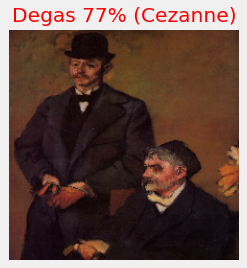

In [93]:
plot_pred(prediction_probabilities=test_predictions, labels=test_labels, images=test_images, n=0)

In [94]:
def plot_test_pred(prediction_probabilities, labels, images, n=0):
    
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
    # Obtem o rótulo pred
    pred_label = get_pred_label(pred_prob)
  
  # Plota imagem e removerticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

  #Altere a cor do título dependendo se a previsão está certa ou errada
    
    color = "green"

    plt.title("{} {:2.0f}%".format(pred_label,
                                      np.max(pred_prob)*100),
                                      color=color)

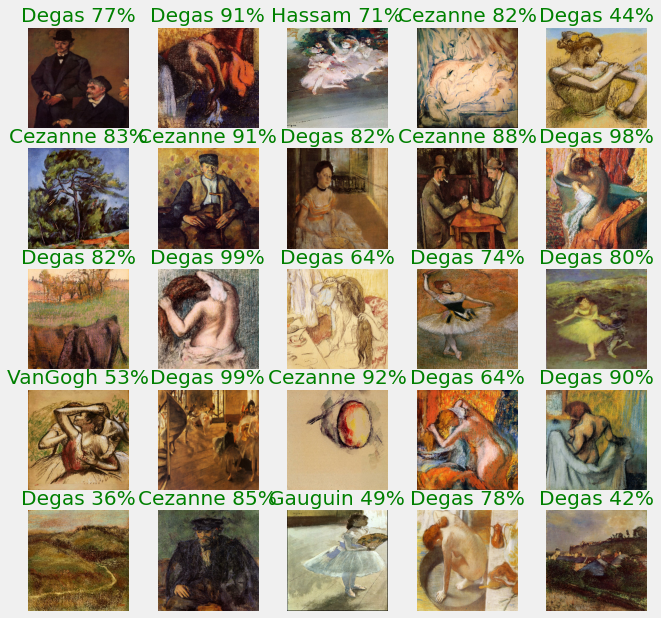

In [95]:
show_test_25_images(images=test_images,label=test_labels,predictions=test_predictions)